In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [2]:
def load_and_prepare_data(seed_dir, seeds_train,
                         is_filename=False):
    train_df = []
    for i in seeds_train:
        if is_filename:
            seed_df = pd.read_csv(seed_dir+i.split('\\')[-1])
        else:
            seed_df = pd.read_csv(seed_dir+f'seir_seed_{i}.csv')
            
        seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
        seed_df['day'] = np.arange(len(seed_df))
        seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
        #seed_df = seed_df[seed_df['Beta'] > 0].copy()
        
        train_df.append(seed_df)
        
    
    train_df = pd.concat(train_df, ignore_index=True)
    train_df = train_df[train_df['Beta'] > 0].copy()
    
    pop = train_df.iloc[0,:4].sum()
    train_df.iloc[:,:4] = train_df.iloc[:,:4]#/pop
    train_df.loc[:,'prev_I'] = train_df.loc[:,'prev_I']#/pop
    #train_df.loc[:,'Beta'] = train_df.loc[:,'Beta'].replace(0, 1e-7)
    #train_df.loc[:,'Beta'] = train_df.loc[:,'Beta'].fillna(1e-7)
    train_df['log_Beta'] = np.log(train_df['Beta'])
    return train_df


def train_model(train_df, model_file,features):
    X = train_df[features].values
    y = train_df['log_Beta'].values

    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(include_bias=False, degree=3),
        SGDRegressor(alpha=0.0001, max_iter=5000, 
                     penalty='l2', warm_start=False)
    )
    model.fit(X, y)
    print(model.score(X, y))
    # Сохраняем лучшую модель
    joblib.dump(model, model_file)

    
def plot(model_file, features):
    model = joblib.load(model_file)
    X = train_df[features].values
    y = train_df['log_Beta'].values
    pred = model.predict(X)
    
    print('MSE: ', mean_squared_error(y, pred))
    fig = plt.figure(figsize=(5, 3)) 
    plt.plot(y, ls='', marker='.')
    plt.plot(pred, ls='', marker='.')
    plt.grid()


In [3]:
# мб нормальную модель авторегрессии?
df_seeds = pd.read_csv('initial_data/seeds_set_parameters.csv')
seeds_train = df_seeds[df_seeds.set!='test']['seed_number'].values
features = ['day', 
            #'prev_I', 
            'S', 
            'E', 
            'I', 
            #'R'
           ]

## barabasi-albert

0.7264856636686996
MSE:  0.1303725308540403


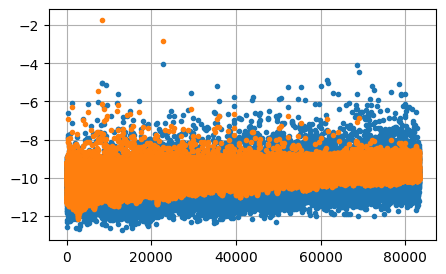

In [4]:
seed_dir='initial_data/initial_data_ba_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'


train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

In [39]:
seed_dir='initial_data/initial_data_ba_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

FileNotFoundError: [Errno 2] No such file or directory: 'initial_data/initial_data_ba_50000/seir_seed_0.csv'

0.7742044013608336


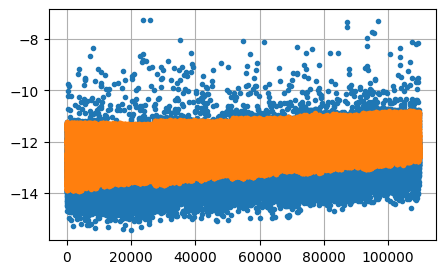

In [71]:
seed_dir='initial_data/initial_data_ba_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

### new

In [14]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values


seed_dir='initial_data/new_ba_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)

0.8358873087096834
MSE:  0.12812100067902968


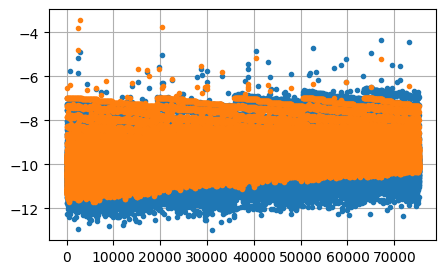

In [15]:
train_model(train_df, model_file, features)
plot(model_file, features)

## small world

0.7831986579904753


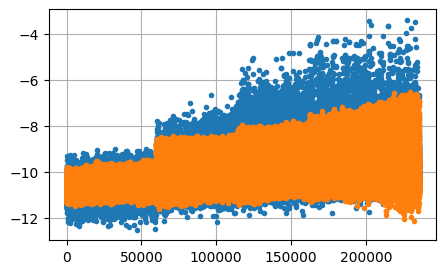

In [73]:
seed_dir='initial_data/initial_data_sw_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.7995411630648883


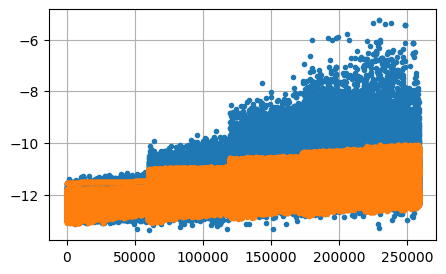

In [84]:
seed_dir='initial_data/initial_data_sw_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.8006524916040959


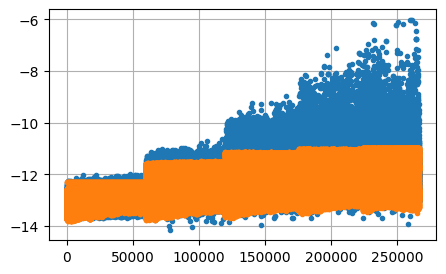

In [86]:
seed_dir='initial_data/initial_data_sw_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

## random

0.5618567014420793
MSE:  0.11139942909935087


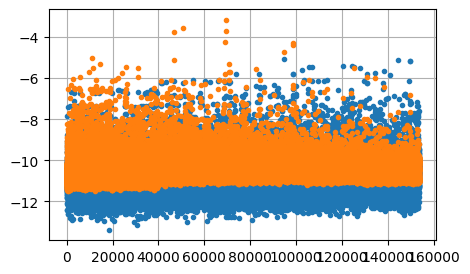

In [5]:
seed_dir='initial_data/initial_data_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.5955909773013708
MSE:  0.11026524559092088


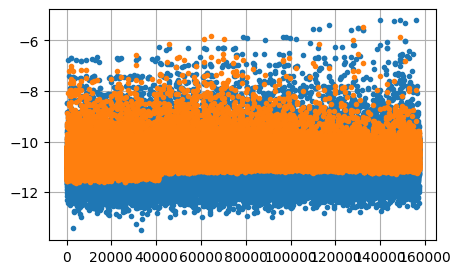

In [6]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values

seed_dir='initial_data/new_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6352484969279337
MSE:  0.10081997521356312


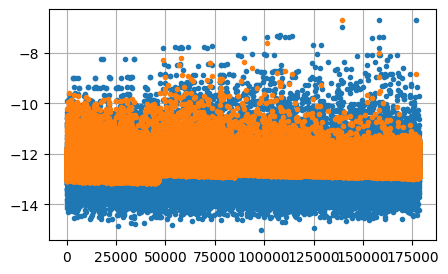

In [5]:
seed_dir='initial_data/initial_data_r_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6529889991426283
MSE:  0.09847972522478192


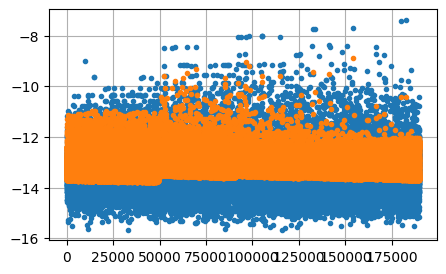

In [7]:
seed_dir='initial_data/initial_data_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.6737600829699402
MSE:  0.10073813081773021


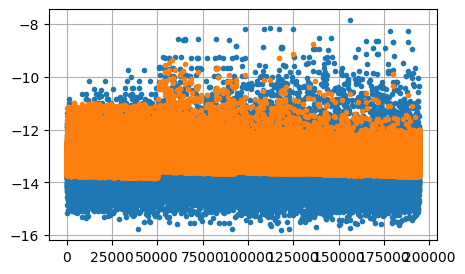

In [8]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values

seed_dir='initial_data/new_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)
train_model(train_df, model_file, features)
plot(model_file, features)